<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Missing-at-Random" data-toc-modified-id="Missing-at-Random-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Missing at Random</a></span></li><li><span><a href="#Structured-Missing" data-toc-modified-id="Structured-Missing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Structured Missing</a></span><ul class="toc-item"><li><span><a href="#Horizontal-Half-Mask" data-toc-modified-id="Horizontal-Half-Mask-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Horizontal Half Mask</a></span></li><li><span><a href="#Vertical-Half-Mask" data-toc-modified-id="Vertical-Half-Mask-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Vertical Half Mask</a></span></li></ul></li><li><span><a href="#Oneshot-Prediction" data-toc-modified-id="Oneshot-Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Oneshot Prediction</a></span></li><li><span><a href="#Autoregressive-Prediction" data-toc-modified-id="Autoregressive-Prediction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Autoregressive Prediction</a></span></li></ul></div>

# Tutorial 5 :  Neural Process Images

Last Update : 1 September 2019

**Aim**: 
- Test the best models (CCP and AttnNP) on image inputs.

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Environment

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


# Dataset 

- MNIST
- CelebA32
- CelebA64

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split

In [7]:
#celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
#celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
#svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
#mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")
zs_mnist_train, zs_mnist_test = get_dataset("zs-mnist")(split="train"), get_dataset("zs-mnist")(split="test")


# celeba64 not fully trained yet
train_datasets_32 = {"mnist":mnist_train, "celeba32":celeba32_train}
test_datasets_32 = {"mnist":mnist_test, "celeba32":celeba32_test}
train_datasets_64 = {"celeba64":celeba64_train, "zs-multi-mnist":zs_mmnist_train}
test_datasets_64 = {"celeba64":celeba64_train, "zs-multi-mnist":zs_mmnist_test}

INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


NameError: name 'mnist_train' is not defined

In [8]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [ ]:
plot_dataset_samples_imgs(celeba32_test, figsize=(9,5))

In [ ]:
plot_dataset_samples_imgs(celeba64_test, figsize=(9,5))

In [ ]:
plot_dataset_samples_imgs(mnist_test, figsize=(9,5))

In [ ]:
plot_dataset_samples_imgs(zs_mmnist_train, figsize=(9,5))
plot_dataset_samples_imgs(zs_mmnist_test, figsize=(9,5))

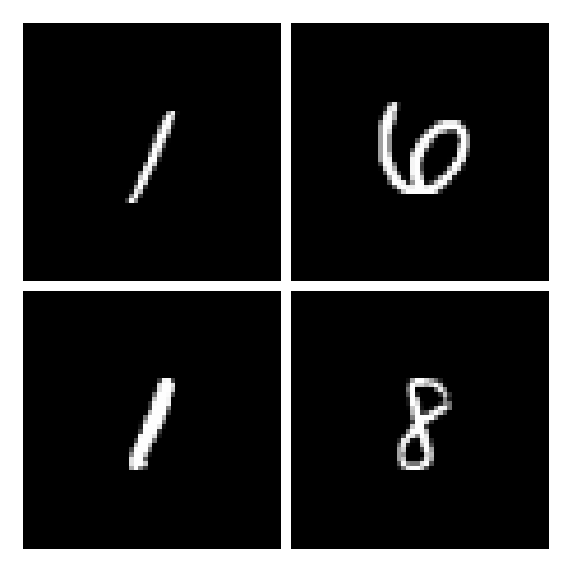

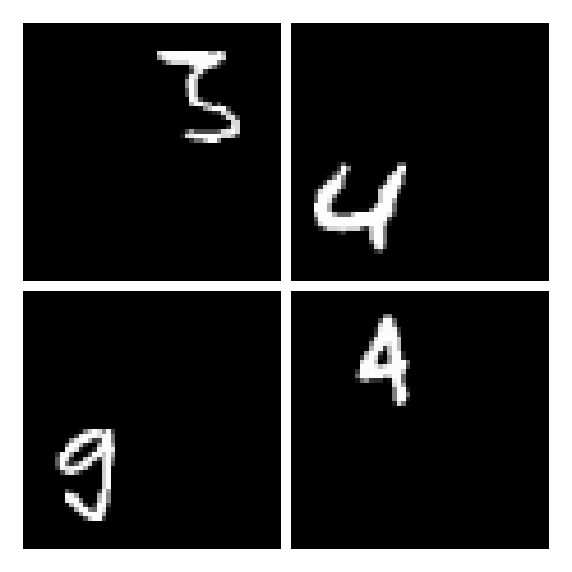

In [12]:
plot_dataset_samples_imgs(zs_mnist_train, figsize=(9,5))
plot_dataset_samples_imgs(zs_mnist_test, figsize=(9,5),seed=249)

In [ ]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

# Model

In [8]:
X_DIM = 2  # 2D spatial input 

In [9]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

ModuleNotFoundError: No module named 'neuralproc'

In [ ]:
from train_imgs import get_model

# models that take into account the grid
models_grided_64 = {}
models_grided_64["GridedCCP"] = get_model("GridedCCP", no_batchnorm=True, img_shape=(64,64))


models_grided_32 = {}
models_grided_32["GridedCCP"] = get_model("GridedCCP", no_batchnorm=True, img_shape=(32,32))

In [ ]:
from utils.helpers import count_parameters
    
for k,v in models_grided.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))

In [ ]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [ ]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

In [ ]:
trainers_grided_64 = train_models(train_datasets_64, 
                                 add_y_dim(models_grided_64, train_datasets_64),
                                 NeuralProcessLoss,
                                 #test_datasets=test_datasets_64,
                                 chckpnt_dirname="results/iclr_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

In [ ]:
trainers_grided_32 = train_models(train_datasets_32, 
                                 add_y_dim(models_grided_32, train_datasets_32),
                                 NeuralProcessLoss,
                                 #test_datasets=test_datasets_64,
                                 chckpnt_dirname="results/iclr_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

# One Shot Inference 

In [10]:
from functools import partial
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE


ModuleNotFoundError: No module named 'neuralproc'

## Missing at Random

random with only 5 % of the data. The distribution show the distribution of log likelihood for the entire test set. The qualitative results are the images (from left to right) corresponding to 1% 50% and 99% percentile for `GridedCCP` folowed by 1% 50% and 99% percentile for `AttnCCP`.

The first row is `GridedCCP`, while the second is `AttnCCP`.



In [11]:
trainers_compare = trainers_grided.copy()
trainers_compare.update(trainers_general)

NameError: name 'trainers_grided' is not defined

In [12]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_compare.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(11, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

NameError: name 'test_datasets' is not defined

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets_64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                             target_masker=no_masker), 
                         trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])

    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets_32.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                             target_masker=no_masker), 
                         trainers_grided_32['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])

    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "zs-multi-mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=partial(AutoregressivePredictor, 
                                                   gen_autoregressive_trgts=GenNextAutoregressivePixelL1(1)),
                             n_plots=8,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets.items()):
    if data_name == "zs-multi-mnist":
        _=plot_posterior_img(data_test, 
                             GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.2, max_nnz=.2, is_batch_share=True),
                                                 target_masker=no_masker), 
                             trainers_grided['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                             MeanPredictor=VanillaPredictor,
                             n_plots=8,
                             is_uniform_grid=True,
                             ax=axes)

        axes.set_title("GridedCCP " + data_name, fontsize=18)

## Structured Missing

### Horizontal Half Mask

NameError: name 'test_datasets_64' is not defined

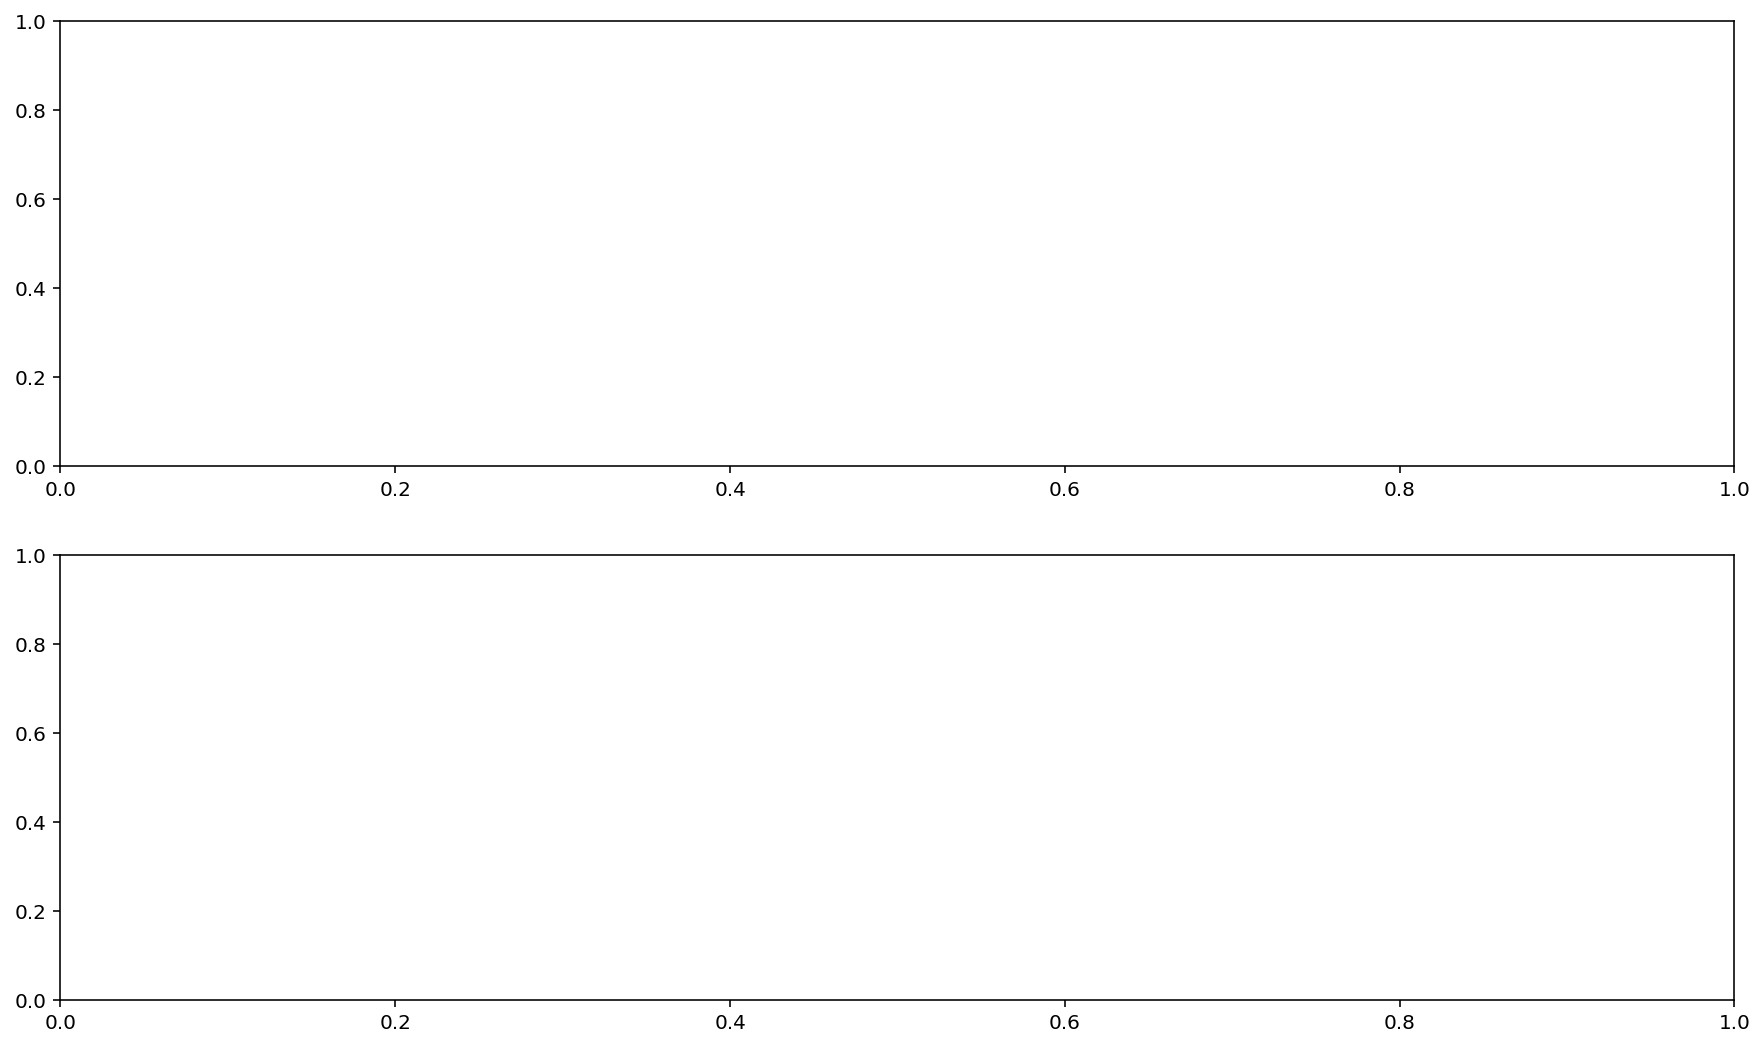

In [13]:
fig, axes = plt.subplots(2,1, figsize=(15, 9))
        
for i, (data_name, data_test) in enumerate(test_datasets_64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=47, max_nnz=47, is_batch_share=True),
                                             target_masker=no_masker), 
                         trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])

    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets_32),1, figsize=(15, 9))

if len(test_datasets_32) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_32.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_grided_32['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets_64),1, figsize=(15, 9))

if len(test_datasets_64) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1),
                                             target_masker=no_masker), 
                         trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

### Vertical Half Mask

In [ ]:
fig, axes = plt.subplots(len(test_datasets_32),1, figsize=(15, 9))

if len(test_datasets_32) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_32.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0),
                                             target_masker=no_masker), 
                         trainers_grided_32['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets_64),1, figsize=(15, 9))

if len(test_datasets_64) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0),
                                             target_masker=no_masker), 
                         trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("GridedCCP " + data_name, fontsize=18)

# Autoregressive Inference 

Autoregressive is as James suggested : predict all neighbors (1 manhattan distance) of context, treat it as context, predict next neighbours.

In [ ]:
for data_name, test_data in test_datasets.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.05, max_nnz=.05, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
AutoregressivePredictor??

In [ ]:
fig, axes = plt.subplots(len(test_datasets_32),1, figsize=(15, 9))

if len(test_datasets_32) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_32.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided_32['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=partial(AutoregressivePredictor, 
                                               gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

In [ ]:
fig, axes = plt.subplots(len(test_datasets_64),1, figsize=(15, 9))

if len(test_datasets_64) ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets_64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=partial(AutoregressivePredictor, 
                                               gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedCCP " + data_name, fontsize=18)

# CelebA64

I did not plot all CelebA64, as not all models are trained yet. Here I show `GridedUnetCCP` which finished training.

In [ ]:
train_datasets64 = dict(celeba64=celeba64_train)
test_datasets64 = dict(celeba64=celeba64_test)

In [ ]:
trainers_grided64 = train_models(train_datasets64, 
                                 add_y_dim(dict(GridedUnetCCP=GridedUnetCCP), train_datasets64),
                                 NeuralProcessLoss,
                                 test_datasets=test_datasets64,
                                 chckpnt_dirname="results/neural_process_imgs/", 
                                 is_retrain=False, 
                                 train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
                                 iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                                               is_return_masks=True),
                                 patience=10,
                                 seed=123) 

## Oneshot Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=VanillaPredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=VanillaPredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

## Autoregressive Prediction

In [ ]:
for data_name, test_data in test_datasets64.items():
    test_loglike = plot_qualitative_with_kde({k:v for k,v in trainers_grided64.items() if data_name in k},
                                     test_data,
                                     GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=.1, max_nnz=.1, is_batch_share=True),
                                                         target_masker=no_masker),
                                      MeanPredictor=AutoregressivePredictor,
                                     figsize=(6, 2), 
                                     percentiles=[1,50,99],
                                     title=data_name)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=1), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)

In [ ]:
n_datasets = len(test_datasets64)

fig, axes = plt.subplots(n_datasets,1, figsize=(15, 4))

if n_datasets ==1:
    axes = [axes]
        
for i, (data_name, data_test) in enumerate(test_datasets64.items()):
    _=plot_posterior_img(data_test, 
                         GridCntxtTrgtGetter(context_masker=partial(half_masker, dim=0), 
                                             target_masker=no_masker), 
                         trainers_grided64['{}/GridedUnetCCP/run_0'.format(data_name)].module_.cpu(), 
                         MeanPredictor=AutoregressivePredictor,
                         n_plots=4,
                         is_uniform_grid=True,
                         ax=axes[i])
    
    axes[i].set_title("Autoregressive GridedUnetCCP " + data_name, fontsize=18)